<a href="https://colab.research.google.com/github/Gilnanderson/reconhecimento-facial/blob/main/reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import os
import copy
import joblib
import pathlib
import kagglehub
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

path_save_models = 'models'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

# ===============================
# 1. Configuração e Download do Dataset
# ===============================

# Caminhos de origem e destino
origem = "/root/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1/Celebrity Faces Dataset"
destino = "/content/datasets/CelebrityFaces"

# Criar o diretório de destino, se não existir
os.makedirs(destino, exist_ok=True)

# Transferir todas as pastas e arquivos
for item in os.listdir(origem):
    item_origem = os.path.join(origem, item)
    item_destino = os.path.join(destino, item)

    if os.path.isdir(item_origem):
        shutil.move(item_origem, item_destino)
    else:
        shutil.move(item_origem, destino)

print("Transferência concluída!")

class CustomDataset(Dataset):
    def __init__(self, path_images, labels, transform, transform_augmentation=None):
        self.path_images = path_images
        self.labels = labels
        self.transform = transform
        self.augmentation = transform_augmentation
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(self.path_images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.augmentation:
            img = self.augmentation(img)
        else:
            img = self.transform(img)

        return img, torch.tensor(np.array([label]), dtype=torch.float32)



Device: cuda
Transferência concluída!


In [26]:
def get_image_path(path):
    X = []
    y = []
    id_to_class = {}
    for cls, folder in enumerate(os.listdir(path)):
        id_to_class[cls] = folder
        full_path = os.path.join(path, folder)
        for filename in os.listdir(full_path):
            if filename.endswith(('jpg', 'png')):  # Melhor prática para verificar múltiplas extensões
                X.append(os.path.join(full_path, filename))
                y.append(cls)
    return X, y, id_to_class

# Definição do caminho dos dados
path_train = '/content/datasets/CelebrityFaces'
path_save_models = "/content/models"

# Criar diretório de salvamento caso não exista
os.makedirs(path_save_models, exist_ok=True)

# Obter caminhos das imagens e rótulos
X_train, y_train, id_to_class = get_image_path(path_train)

# Aplicar One-Hot Encoding nos rótulos
one_hot = OneHotEncoder(sparse_output=False)
y_train = one_hot.fit_transform(np.array(y_train).reshape(-1, 1))

# Salvar o encoder treinado
joblib.dump(one_hot, os.path.join(path_save_models, 'oneHot_celebrity.joblib'))

# Dividir os dados em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

# Exibir o mapeamento das classes
id_to_class


{0: 'Kate Winslet',
 1: 'Tom Cruise',
 2: 'Johnny Depp',
 3: 'Megan Fox',
 4: 'Tom Hanks',
 5: 'Hugh Jackman',
 6: 'Sandra Bullock',
 7: 'Angelina Jolie',
 8: 'Nicole Kidman',
 9: 'Scarlett Johansson',
 10: 'Natalie Portman',
 11: 'Brad Pitt',
 12: 'Will Smith',
 13: 'Leonardo DiCaprio',
 14: 'Denzel Washington',
 15: 'Jennifer Lawrence',
 16: 'Robert Downey Jr'}

In [27]:
pd.DataFrame.from_dict(id_to_class, orient='index').to_csv(f'{path_save_models}/id_to_class_celebrity.csv', header=None)

print(one_hot.transform([[0]]))
print(one_hot.transform([[1]]))
print(one_hot.transform([[2]]))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [28]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(one_hot.transform([[0]])[0]))
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

transform_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [30]:
dataset_train = CustomDataset(X_train, y_train, transform_default, transform_augmentation)
dataset_valid = CustomDataset(X_valid, y_valid, transform_default)

train_loader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=32,
                    shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)

valid_loader = torch.utils.data.DataLoader(
                dataset_valid, batch_size=32,
                shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

In [31]:
log_name = ''
dataset_name = 'celebrity'
total_epoch = 20


if log_name != '':
    writer = SummaryWriter(f'runs/{log_name}')  # 'runs/50'
else:
    writer = SummaryWriter()

results = []
# acc, loss, epoch
best_acc = [0., 0., 0]

for epoch in range(total_epoch):
    torch.cuda.empty_cache()
    model.train()
    running_loss = 0.
    running_accuracy = 0.
    running_p = []
    running_y = []
    for data in tqdm(train_loader):
        inputs, labels = data
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(torch.softmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calcule accuracy
        outputs = outputs.cpu().detach()
        labels = labels.cpu().detach()
        output_probs, top_class_output = outputs.topk(k = 1, dim = 1)
        label_probs, top_class_label = labels.topk(k = 1, dim = 1)
        running_accuracy += accuracy_score(top_class_label, top_class_output)
    writer.add_scalar(f'{dataset_name}-Accuracy/train', running_accuracy/len(train_loader), epoch)
    writer.add_scalar(f'{dataset_name}-Loss/train', running_loss/len(train_loader), epoch)
    print('Epoch {}; Loss {}; Accuracy {}'.format(epoch, running_loss/len(train_loader), running_accuracy/len(train_loader)))

    if epoch % 1 == 0:
        model.eval()
        running_accuracy_valid = 0.
        running_loss_valid = 0.
        running_p2 = []
        running_y2 = []
        for data in tqdm(valid_loader):
            inputs_valid, labels_valid = data
            labels_valid = labels_valid.squeeze(1)

            inputs_valid = inputs_valid.to(device)
            labels_valid = labels_valid.to(device)

            outputs_valid = model(inputs_valid)
            loss = criterion(torch.softmax(outputs_valid, dim=1), labels_valid)
            running_loss_valid += loss.item()

            # Calcule accuracy
            outputs_valid = outputs_valid.cpu().detach()
            labels_valid = labels_valid.cpu().detach()
            output_valid_probs, top_class_output = outputs_valid.topk(k = 1, dim = 1)
            label_probs_valid, top_class_label = labels_valid.topk(k = 1, dim = 1)
            running_accuracy_valid += accuracy_score(top_class_label, top_class_output)
        writer.add_scalar(f'{dataset_name}-Accuracy/valid', running_accuracy_valid/len(valid_loader), epoch)
        writer.add_scalar(f'{dataset_name}-Loss/valid', running_loss_valid/len(valid_loader), epoch)
        print(f'Loss valid {running_loss_valid/len(valid_loader)}; Accuracy valid:{running_accuracy_valid/len(valid_loader)}')
        if running_accuracy_valid/len(valid_loader) > best_acc[0]:
            print('### New best model! ###')
            best_acc = [running_accuracy_valid/len(valid_loader), running_loss_valid/len(valid_loader), epoch]
            best_model = copy.deepcopy(model)
    writer.flush()
writer.flush()

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 0; Loss 0.04407684444341549; Accuracy 0.3907461240310077


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.03517399989068508; Accuracy valid:0.5458333333333333
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1; Loss 0.02843073162055293; Accuracy 0.6385658914728682


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.032347129036982857; Accuracy valid:0.5833333333333334
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2; Loss 0.020980288014682227; Accuracy 0.7386143410852714


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.0343275564412276; Accuracy valid:0.5729166666666666


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3; Loss 0.017637752732911776; Accuracy 0.7969961240310078


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.01931786841402451; Accuracy valid:0.7729166666666667
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4; Loss 0.012126011811846565; Accuracy 0.8522286821705427


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.025348476693034173; Accuracy valid:0.6958333333333333


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5; Loss 0.01071364767741152; Accuracy 0.8808139534883721


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.023755880321065584; Accuracy valid:0.7041666666666667


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6; Loss 0.012728077451546872; Accuracy 0.8582848837209303


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.02280188339451949; Accuracy valid:0.7125


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7; Loss 0.009493428109170393; Accuracy 0.8895348837209303


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.02026387999455134; Accuracy valid:0.775
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8; Loss 0.008710688751645733; Accuracy 0.902374031007752


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.017694710629681747; Accuracy valid:0.8020833333333334
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9; Loss 0.007059029414491771; Accuracy 0.9234496124031009


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.021631408017128706; Accuracy valid:0.75625


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10; Loss 0.006136149540949656; Accuracy 0.9382267441860465


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.021767911966890097; Accuracy valid:0.7604166666666666


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11; Loss 0.005276075280731717; Accuracy 0.939437984496124


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.019174506266911823; Accuracy valid:0.775


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12; Loss 0.004136448727073256; Accuracy 0.9539728682170543


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.016513206313053766; Accuracy valid:0.8


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13; Loss 0.003799515429459144; Accuracy 0.9546996124031009


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.011320000234991311; Accuracy valid:0.8541666666666666
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14; Loss 0.005191503969822512; Accuracy 0.9396802325581395


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.018372580331439774; Accuracy valid:0.8


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15; Loss 0.006162162430227063; Accuracy 0.9358042635658915


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.01911763617148002; Accuracy valid:0.76875


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16; Loss 0.0034926704954772883; Accuracy 0.9600290697674418


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.012625259525763492; Accuracy valid:0.8666666666666667
### New best model! ###


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17; Loss 0.003057679891901708; Accuracy 0.9656007751937985


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.01876307325437665; Accuracy valid:0.8


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 18; Loss 0.003583783639759383; Accuracy 0.9622093023255814


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.01639721660564343; Accuracy valid:0.8125


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19; Loss 0.003444932326178681; Accuracy 0.9571220930232558


  0%|          | 0/15 [00:00<?, ?it/s]

Loss valid 0.015128899520883957; Accuracy valid:0.81875


In [32]:
pathlib.Path(path_save_models).mkdir(exist_ok=True, parents=True)
torch.save(best_model, f'{path_save_models}/celebrity.pth')

In [33]:
best_model = torch.load(f'{path_save_models}/celebrity.pth')
one_hot = joblib.load(f'{path_save_models}/oneHot_celebrity.joblib')
id_to_class = pd.read_csv(f'{path_save_models}/id_to_class_celebrity.csv', index_col=0, header=None)[1].T.to_dict()

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

<ipython-input-33-2e108d7512d9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(f'{path_save_models}/celebrity.pth')


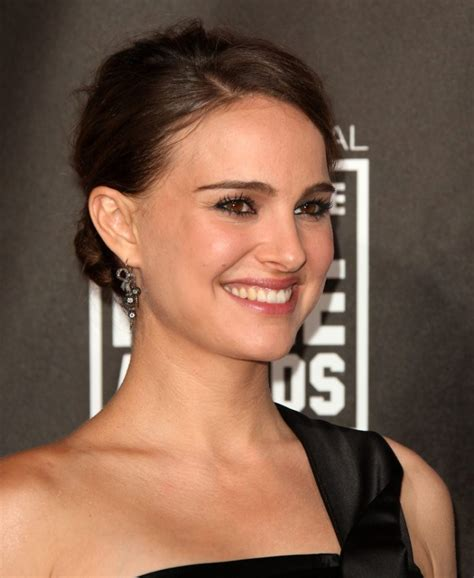

In [34]:
idx = 0
img = Image.open(X_valid[idx]).convert('RGB')
img

In [35]:
input_data = transform_default(img).unsqueeze(0).to(device)
output = best_model(input_data)
output_softmax = torch.softmax(output, dim=1)
output_valid_probs, top_class_output = output_softmax.topk(k = 1, dim = 1)
label_probs_valid, top_class_label = torch.Tensor(y_valid[idx]).unsqueeze(0).topk(k = 1, dim = 1)
print(f'Real: {top_class_label[0][0]}-{id_to_class[int(top_class_label[0][0])]}' +
      f' - pred_class: {top_class_output[0][0]}-{id_to_class[int(top_class_output[0][0])]}' +
      f'\nPred_prob: {output_softmax}')

Real: 10-Natalie Portman - pred_class: 10-Natalie Portman
Pred_prob: tensor([[8.6993e-05, 1.3753e-04, 1.5830e-05, 4.1828e-05, 1.6102e-05, 4.0540e-06,
         1.3577e-04, 2.2468e-04, 2.2768e-04, 1.1777e-05, 9.9892e-01, 2.4811e-06,
         2.7651e-06, 5.9832e-06, 3.2508e-06, 1.3733e-04, 2.9121e-05]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [36]:
pred = []
for data in tqdm(X_valid):
    img = Image.open(data).convert('RGB')
    input_data = transform_default(img).unsqueeze(0).to(device)
    output = best_model(input_data)
    result = torch.softmax(output, dim=1).cpu().detach()
    pred.append(result)

  0%|          | 0/450 [00:00<?, ?it/s]

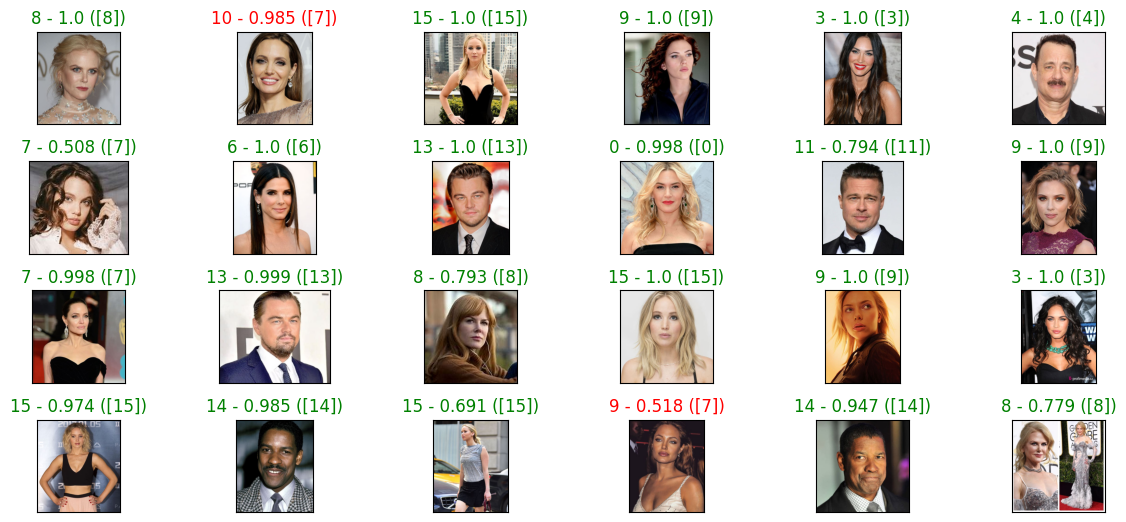

In [37]:
# Exibe alguns exemplos aleatorios do teste, bem como sua predicao e o resultado esperado
num_x = 6
num_y = 4
fig = plt.figure(figsize=(num_y, num_x))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
fig.set_figheight(6)
fig.set_figwidth(14)
y = one_hot.inverse_transform(y_valid)
for i, idx in enumerate(np.random.choice((len(X_valid)), size=num_x*num_y, replace=False)):
    ax = fig.add_subplot(num_y, num_x, i + 1, xticks=[], yticks=[])
    ax.imshow(Image.open(X_valid[idx]).convert('RGB'))
    top_prob, top_class = pred[idx].topk(k = 1, dim = 1)
    ax.set_title("{} - {} ({})".format(int(top_class[0][0]), round(float(top_prob), 3), y[idx]),
                 color=("green" if int(top_class[0][0]) == y[idx] else "red"))

Accuracy: 0.8577777777777778


<Axes: >

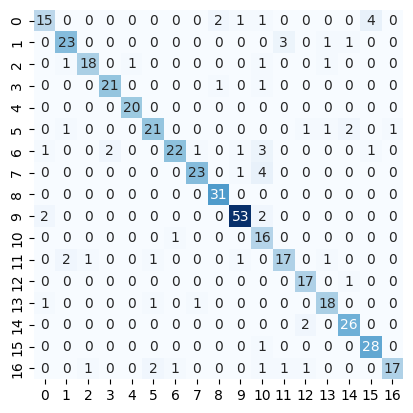

In [38]:
top_probs, top_classes = torch.cat(pred).topk(k = 1, dim = 1)
conf_matrix = confusion_matrix(one_hot.inverse_transform(y_valid), top_classes)
print(f'Accuracy: {accuracy_score(one_hot.inverse_transform(y_valid), top_classes)}')
sns.heatmap(conf_matrix, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

Device: cuda
Class Names: ['Kate Winslet', 'Tom Cruise', 'Johnny Depp', 'Megan Fox', 'Tom Hanks', 'Hugh Jackman', 'Sandra Bullock', 'Angelina Jolie', 'Nicole Kidman', 'Scarlett Johansson', 'Natalie Portman', 'Brad Pitt', 'Will Smith', 'Leonardo DiCaprio', 'Denzel Washington', 'Jennifer Lawrence', 'Robert Downey Jr']


<ipython-input-61-1b8ece8fdd75>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


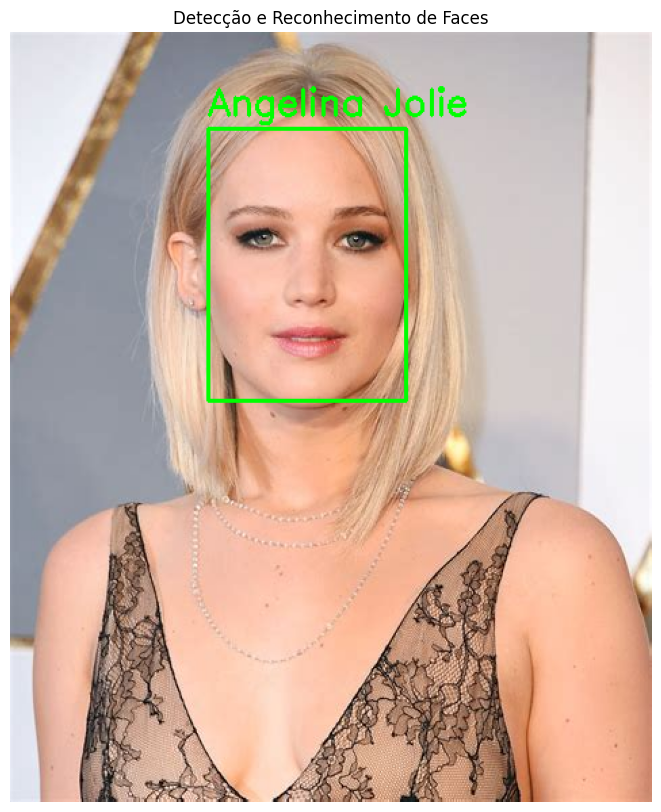

Predições: ['Angelina Jolie']


In [61]:
# Instale as bibliotecas necessárias, se ainda não estiverem instaladas
!pip install -q mtcnn kagglehub

import os
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mtcnn import MTCNN
import pandas as pd
!pip install lz4


# Configure o dispositivo (GPU T4 no Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

##############################################
# Definir a transformação (deve ser a mesma do treinamento)
##############################################
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transform_default = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

##############################################
# Função para detectar e alinhar rostos usando MTCNN
##############################################
def detect_and_align_faces(image):
    """
    Detecta e alinha rostos em uma imagem usando MTCNN.
    Retorna uma lista de faces alinhadas (como imagens PIL convertidas para numpy)
    e as caixas delimitadoras correspondentes.
    """
    detector = MTCNN()
    faces = detector.detect_faces(np.array(image))
    aligned_faces = []
    boxes = []
    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)  # Corrige coordenadas negativas
        # Usamos PIL para recortar o rosto
        cropped = image.crop((x, y, x + w, y + h))
        if cropped.size[0] == 0 or cropped.size[1] == 0:
            continue
        cropped = cropped.resize((224, 224))
        aligned_faces.append(cropped)
        boxes.append((x, y, w, h))
    return aligned_faces, boxes

##############################################
# Função para detecção e reconhecimento de múltiplas faces
##############################################
def detect_and_recognize_faces(image_path, model, transform, class_names):
    """
    Carrega uma imagem, detecta e alinha as faces usando MTCNN e, em seguida,
    classifica cada face com o modelo treinado.
    Desenha as caixas delimitadoras e os rótulos na imagem.
    """
    # Carregar a imagem com PIL
    image = Image.open(image_path).convert('RGB')

    # Detectar e alinhar rostos
    aligned_faces, boxes = detect_and_align_faces(image)

    # Converter a imagem para OpenCV para desenhar as caixas (necessário para exibição final)
    image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    predictions = []
    for face in aligned_faces:
        # Aplicar o mesmo transform utilizado no treinamento
        face_tensor = transform(face).unsqueeze(0).to(device)
        # Realizar a predição
        output = model(face_tensor)
        _, predicted = torch.max(output, 1)
        pred_label = class_names[predicted.item()]
        predictions.append(pred_label)

    # Desenhar as caixas e os rótulos na imagem
    for (x, y, w, h), label in zip(boxes, predictions):
        cv2.rectangle(image_cv2, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_cv2, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Exibir a imagem final com as detecções
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Detecção e Reconhecimento de Faces')
    plt.show()

    return predictions

##############################################
# Carregar o Modelo Treinado e a Lista de Classes
##############################################
# Suponha que seu modelo treinado foi salvo como 'final_face_recognition_model.pth'
model_path = "/content/models/celebrity.pth"  # Altere para o caminho correto, se necessário
model = torch.load(model_path, map_location=device)
model.eval()  # Colocar o modelo em modo de avaliação

# Defina a lista de classes (exemplo: você pode ter salvo essa lista durante o treinamento)
# Exemplo:
# CLASS_NAMES = ["Brad Pitt", "Tom Cruise", "Angelina Jolie", ... ]
# Certifique-se de que a ordem é a mesma do seu treinamento
# Se você tiver salvo o mapeamento de classes, carregue-o; caso contrário, defina manualmente:


# Carrega o CSV, considerando que a primeira coluna é o índice e a segunda contém os nomes das classes
df = pd.read_csv('/content/models/id_to_class_celebrity.csv', header=None, index_col=0)

# Converte a segunda coluna para uma lista de nomes de classes
CLASS_NAMES = df[1].tolist()

print("Class Names:", CLASS_NAMES)


##############################################
# Teste de Inferência: Detecção e Reconhecimento em uma Imagem Nova
##############################################
test_image_path = "/content/datasets/CelebrityFaces/Jennifer Lawrence/008_35fbbb0c.jpg"  # Substitua pelo caminho da sua imagem de teste
predictions = detect_and_recognize_faces(test_image_path, model, transform_default, CLASS_NAMES)
print("Predições:", predictions)


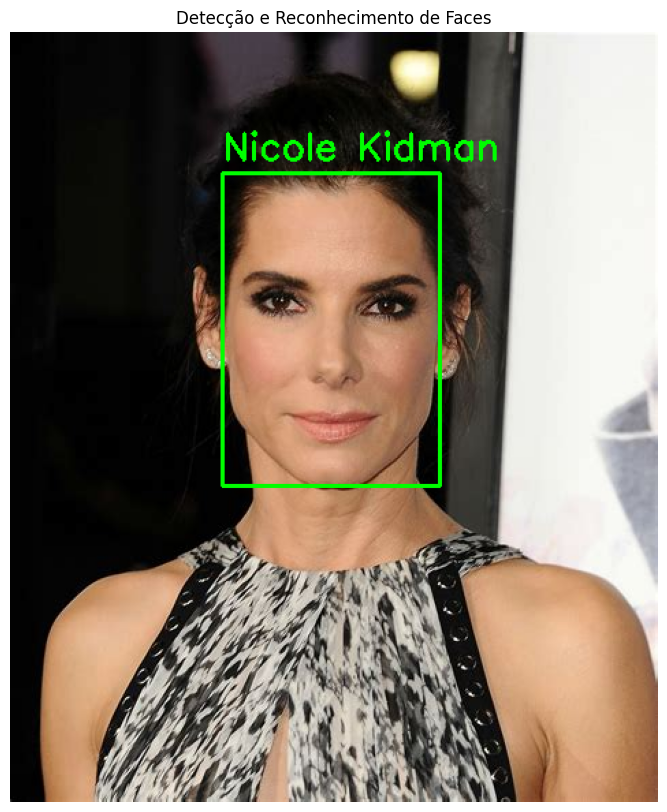

Predições: ['Nicole Kidman']


In [69]:
##############################################
# Teste de Inferência: Detecção e Reconhecimento em uma Imagem Nova
##############################################
test_image_path = "/content/datasets/CelebrityFaces/Sandra Bullock/001_5ef3e95c.jpg"  # Substitua pelo caminho da sua imagem de teste
predictions = detect_and_recognize_faces(test_image_path, model, transform_default, CLASS_NAMES)
print("Predições:", predictions)
